## How to use the t-SNE algorithm on APOGEE globular cluster data. 
##### Steffani Grondin (September 23, 2022)

In [ ]:
%pip install sklearn
%pip install shapely

## Notes for this program

My parameter list is different from Steffani's. My param list is shown below:\\\\
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR', 'SNR', 'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']\\\\

So basically the RA index is 4, DEC index is 5, RV index is 10, and the first chemical abundance is at 13. The chemical abundances follow Steffani's form (e.g. abundance1, abundance1_error, abundance2, abundance2_error, etc.). What I did was make the standardizing step for both tSNE and UMAP take in the index of the first chemical abundance and from there it automatically adds 2 for each chem abundance going up.\\\\

Basically if you use my param_list it'll work. The param_list variable is just a list of strings of the index titles, I have a function somewhere that grabs the data for those indices.\\\\

For each GC, we just need the ra, dec, rhm_deg (rhm depends on dist I think).\\
There are global parameters for all GCs as well, so the parameter list, fov, and chemical abundance starting index.\\\\

LMK if shit dont work and there's probably something I forgot to explain.

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

### Step 1: Load in the clusters

#### Load in selected star cluster
Input RA and DEC and the program will load in all the stars within a $10^o$ by $10^o$ FOV.

In [55]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')

In [4]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, fov, df):
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov and i <= ra + fov and df['DEC'].values[count] >= dec - fov and df['DEC'].values[count] <= dec + fov:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a 10x10 fov of the GC')

    ra_arr = np.empty(len(stars), dtype=float)
    dec_arr = np.empty(len(stars), dtype=float)
    for count, i in enumerate(stars):
        ra_arr[count] = i['RA']
        dec_arr[count] = i['DEC']

    plt.figure(figsize=(10,10))
    plt.plot(ra_arr, dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.show()
    
    return stars
            

#### Separating list of stars into lists by parameter

In [5]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict
        

#### Separating the dictionary values into a columns list

In [6]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

#### Master GC load function

In [7]:
def master_load(ra, dec, fov, dataset, params):
    stars_found = find_cluster_stars(ra, dec, fov, dataset)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]
    

### Step 2: Filter the data

#### Filter 1 for data: Removing all stars without PM

In [8]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

#### Filter 2 for data: Removing all stars that do not have chemical abundances

In [9]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

#### Filter 3 for data: Removing all duplicate spectra

In [10]:
# changed all indices of 0 to 4 (RA) and 23 to 12 (SNR)
def dup_filter(data_abundancefilter):
    d =  Counter(data_abundancefilter[4])
    #print(d)
    duplicates = [k for k, v in d.items() if v > 1]
    a_list = np.array(range(0, len(duplicates)))
    max_SNR_array = []

    for i in a_list:
        indices = np.where(data_abundancefilter[4] == duplicates[i])
        snr_val = data_abundancefilter[12][indices]
        maximum = max(snr_val)
        # 4 is RA, 12 is SNR
        index_maximum = np.where((data_abundancefilter[4] == duplicates[i]) & (data_abundancefilter[12] == maximum))
        #print(index_maximum[4])
        index_maximum = int(index_maximum[4])
        max_SNR_array.append(index_maximum)

    idx_sort = np.argsort(data_abundancefilter[4])
    sorted_ra_array = data_abundancefilter[4][idx_sort]
    vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count == 1]
    listtest =  np.array(range(0, len(vals)))

    unique_array = []
    for i in listtest:
        unique_val = np.where(vals[i] == data_abundancefilter[4])
        unique_val = int(unique_val[0])
        unique_array.append(unique_val)

    print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
    print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))
    
    if len(max_SNR_array) != 0:
        duplicates_filter = np.concatenate((unique_array, max_SNR_array))
        sortedarray = np.sort(duplicates_filter)

        data_duplicatesfilter = []
        for i in data_abundancefilter:
            z = np.array(i)[duplicates_filter]
            data_duplicatesfilter.append(z)

        print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))
    
    else:
        print('There were no duplicate spectra.')
        data_duplicatesfilter = data_abundancefilter
    
    return data_duplicatesfilter

#### Filter 4 for data: Removing all low SNR

In [11]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    #print(data_snrfilter[12])
    return data_snrfilter

#### Master filter function

In [12]:
def master_filter(GC_dict, GC_cols):
    M3_pm_filter = pm_filter(GC_dict, GC_cols)
    M3_abundance_filter = chem_filter(M3_pm_filter, 13)
    M3_duplicates_filter = dup_filter(M3_abundance_filter)
    M3_SNR_filter = SNR_filter(M3_duplicates_filter)
    
    print('\nThe final amount of stars in our sample is:', len(M3_SNR_filter[0]))
    return M3_SNR_filter

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [13]:
def control_group(data_filter, ra, dec, rhm_deg):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    # Select stars within 8 * r,hm (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, 8*rhm_deg, ra_filtered, dec_filtered)
    indices_control = np.where(in_halfmass==True)

    '''# larger rhm
    in_halfmass_10 = in_circle(ra, dec, 10*rhm_deg, ra_filtered, dec_filtered)
    indices_control_10 = np.where(in_halfmass_10==True)

    # smaller rhm
    in_halfmass_6 = in_circle(ra, dec, 6*rhm_deg, ra_filtered, dec_filtered)
    indices_control_6 = np.where(in_halfmass_6==True)'''

    controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)

    '''controlgroup_10 = []
    for i in data_filter:
        b_10 = np.array(i)[indices_control_10]
        controlgroup_10.append(b_10)

    controlgroup_6 = []
    for i in data_filter:
        b_6 = np.array(i)[indices_control_6]
        controlgroup_6.append(b_6)'''

    # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars in our GC control group.".format(len(ra_control)))

    '''print("There are {} stars in our M3 control group w/ size 10.".format(len(controlgroup_10)))

    print("There are {} stars in our M3 control group w/ size 6.".format(len(controlgroup_6)))'''
    
    return [indices_control]

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.


In [56]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pretsne_array = []
    params_arr = []
    
    for key in param_dict:
        pretsne_array.append(data_filter[param_dict[key]])
        params_arr.append(key)
    
    pretsne_array = np.array(pretsne_array)
    
    standardized = []
    
    for i in pretsne_array:
        #print(i)
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #print(mean)
        norm = (i - mean) / sigma
        standardized.append(norm)
        
    print('The chosen parameters for tSNE and UMAP were:', params_arr)
    return standardized

Function below is depricated. New function is above

In [14]:
'''def standardize_data(data_filter, abundance_index):
    FE_H_filtered, C_FE_filtered, CI_FE_filtered = data_filter[abundance_index], data_filter[abundance_index+2], data_filter[abundance_index+4]
    N_FE_filtered, O_FE_filtered, MG_FE_filtered = data_filter[abundance_index+6], data_filter[abundance_index+8], data_filter[abundance_index+10]
    AL_FE_filtered, SI_FE_filtered, P_FE_filtered = data_filter[abundance_index+12], data_filter[abundance_index+14], data_filter[abundance_index+16]
    S_FE_filtered, K_FE_filtered, CA_FE_filtered = data_filter[abundance_index+18], data_filter[abundance_index+20], data_filter[abundance_index+22]
    TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = data_filter[abundance_index+24], data_filter[abundance_index+26], data_filter[abundance_index+28]
    CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = data_filter[abundance_index+30], data_filter[abundance_index+32], data_filter[abundance_index+34], data_filter[abundance_index+36]
    RV_filtered  = data_filter[10]
    #print([np.isnan(i) for i in RV_filtered])

    pretsne_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                          AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                          TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                           NI_FE_filtered])
    pretsne_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                          AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                          TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                           NI_FE_filtered, RV_filtered])

    standardized = []
    for i in pretsne_array:
        #print(i)
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #print(mean)
        norm = (i - mean) / sigma
        standardized.append(norm)
        
    return standardized'''

Next, we apply the t-SNE algorithm via scikit-learn to reduce the dimensionality of the data from 20-D to 2-D.

In [15]:
def tSNE_alg(standardized_array, indices_control):
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardized_array)

    # Run t-SNE on the transposed array:
    tsne_init = TSNE(n_components=2)
    tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX = tsne_2d[:, 0]
    t_SNE_dimY = tsne_2d[:, 1]

    # Get t-SNE outputs for control group:
    tsne_dimX_control = t_SNE_dimX[indices_control]
    tsne_dimY_control = t_SNE_dimY[indices_control]
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(t_SNE_dimX, t_SNE_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(tsne_dimX_control , tsne_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
    ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
    ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16, loc=1)
    plt.show()
    
    print('Total: ', len(t_SNE_dimX), 'Control: ', len(tsne_dimX_control[0]))
    
    return [t_SNE_dimX, t_SNE_dimY, tsne_dimX_control[0], tsne_dimY_control[0]]

In [58]:
def master_tSNE(data_filter, param_dict, indices_control):
    standardize = standardize_data(data_filter, param_dict)
    
    return tSNE_alg(standardize, indices_control)

Function below is depricated. New function above

In [16]:
'''def master_tSNE(data_filter, abundance_index, indices_control):
    standardize = standardize_data(data_filter, abundance_index)
    
    return tSNE_alg(standardize, indices_control)'''

#### UMAP function

In [57]:
def master_UMAP(data_filter, param_dict, indices_control):
    standardize = standardize_data(data_filter, param_dict)
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(standardize)
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardize)

    # Run t-SNE on the transposed array:
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    umap_dimX = embedding[:, 0]
    umap_dimY = embedding[:, 1]

    # Get t-SNE outputs for control group:
    umap_dimX_control = umap_dimX[indices_control]
    umap_dimY_control = umap_dimY[indices_control]

    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(umap_dimX, umap_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(umap_dimX_control , umap_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
    ax.set_xlabel("UMAP X-Dimension", fontsize=16)
    ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16)
    plt.show()
    print('Total:',len(umap_dimX),'control:',len(umap_dimX_control[0]))
    
    return [umap_dimX, umap_dimY, umap_dimX_control[0], umap_dimY_control[0]]

Function below is depricated. New function above

In [17]:
'''def master_UMAP(data_filter, abundance_index, indices_control):
    standardize = standardize_data(data_filter, abundance_index)
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(standardize)
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardize)

    # Run t-SNE on the transposed array:
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    umap_dimX = embedding[:, 0]
    umap_dimY = embedding[:, 1]

    # Get t-SNE outputs for control group:
    umap_dimX_control = umap_dimX[indices_control]
    umap_dimY_control = umap_dimY[indices_control]

    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(umap_dimX, umap_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(umap_dimX_control , umap_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
    ax.set_xlabel("UMAP X-Dimension", fontsize=16)
    ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16)
    plt.show()
    print('Total:',len(umap_dimX),'control:',len(umap_dimX_control[0]))
    
    return [umap_dimX, umap_dimY, umap_dimX_control[0], umap_dimY_control[0]]'''

#### Choosing which parameters to use for tSNE and UMAP

In [61]:
def ask_input_param(param):
    #print('Do you want to keep', param, 'as a parameter? [y/n]')
    inp = input('Do you want to keep ' + param + ' as a parameter? [y/n]')
    if inp.lower() == 'y':
        return True
    elif inp.lower() == 'n':
        return False
    else:
        print('Not a valid input, trying again')
        return ask_input_param(param)
        

In [64]:
def choose_params(master_param_dict):
    parameter_dict = {}

    for i in master_param_dict:
        if ask_input_param(i):
            parameter_dict[i] = master_param_dict[i]
            
    return parameter_dict

### Master function

In [65]:
def master_func(ra, dec, rhm_deg, master_param_dict, fov, dataset, params):
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    # control grouping
    GC_indices_control = control_group(GC_filter_data, ra, dec, rhm_deg)
    
    # choosing parameters
    param_dict = choose_params(master_param_dict)
    
    # tSNEing
    tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control)
    
    # UMAPing
    UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control)
    
    print('Done!')
    return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

Function below is depricated. New function above

In [18]:
'''def master_func(ra, dec, rhm_deg, abundance_index, fov, dataset, params):
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    # control grouping
    GC_indices_control = control_group(GC_filter_data, ra, dec, rhm_deg)
    
    # tSNEing
    tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, abundance_index, GC_indices_control)
    
    # UMAPing
    UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, abundance_index, GC_indices_control)
    
    print('Done!')
    return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]'''

#### Global GC params

In [67]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'VHELIO_AVG', 'VERR', 'SNR', 'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']
abundance_index = 13
RV_index = 10
PMRA_index = 6
PMDEC_index = 8

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
all_param_dict = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36,
                 'RV': RV_index,
                 'PMRA': PMRA_index,
                 'PMDEC': PMDEC_index}
fov = 5

Parameters for GCs

In [68]:
# M3 (NGC 5272)
ra_M3 = 205.54842 # [deg]
dec_M3 = 28.37728 # [deg]
dist_M3 = 10180  # [pc]
rt_M3 = 159.0339  # [pc] -- tidal radius @ apogalacticon
rhm_M3 = 6.34  # [pc]
rhm_M3_deg = math.degrees(math.atan(rhm_M3 / dist_M3))  # deg
pmra_M3 = -0.152  # [mas/yr]
pmdec_M3 = -2.670  # [mas/yr]

# M13 (NGC 6205)
ra_M13 = 250.42181
dec_M13 = 36.45986
dist_M13 = 7420
rt_M13 = 8640
rhm_M13 = 5.26
rhm_M13_deg = math.degrees(math.atan(rhm_M13 / dist_M13))  # deg

# M2 (NGC 7089)
ra_M2 = 323.36258
dec_M2 = -0.82325
dist_M2 = 11690
rt_M2 = 10540
rhm_M2 = 4.77
rhm_M2_deg = math.degrees(math.atan(rhm_M2 / dist_M2))  # deg

# M12 (NGC 6218)
ra_M12 = 251.80907
dec_M12 = -1.94853
dist_M12 = 5110
rt_M12 = 4570
rhm_M12 = 4.05
rhm_M12_deg = math.degrees(math.atan(rhm_M12 / dist_M12))  # deg

# M10 (NGC 6254)
ra_M10 = 254.28772
dec_M10 = -4.10031
dist_M10 = 5070
rt_M10 = 4350
rhm_M10 = 4.81
rhm_M10_deg = math.degrees(math.atan(rhm_M10 / dist_M10))  # deg

# NGC 6397
ra_NGC6397 = 265.17538
dec_NGC6397 = -53.67434
dist_NGC6397 = 2480
rt_NGC6397 = 6010
rhm_NGC6397 = 3.90
rhm_NGC6397_deg = math.degrees(math.atan(rhm_NGC6397 / dist_NGC6397))  # deg

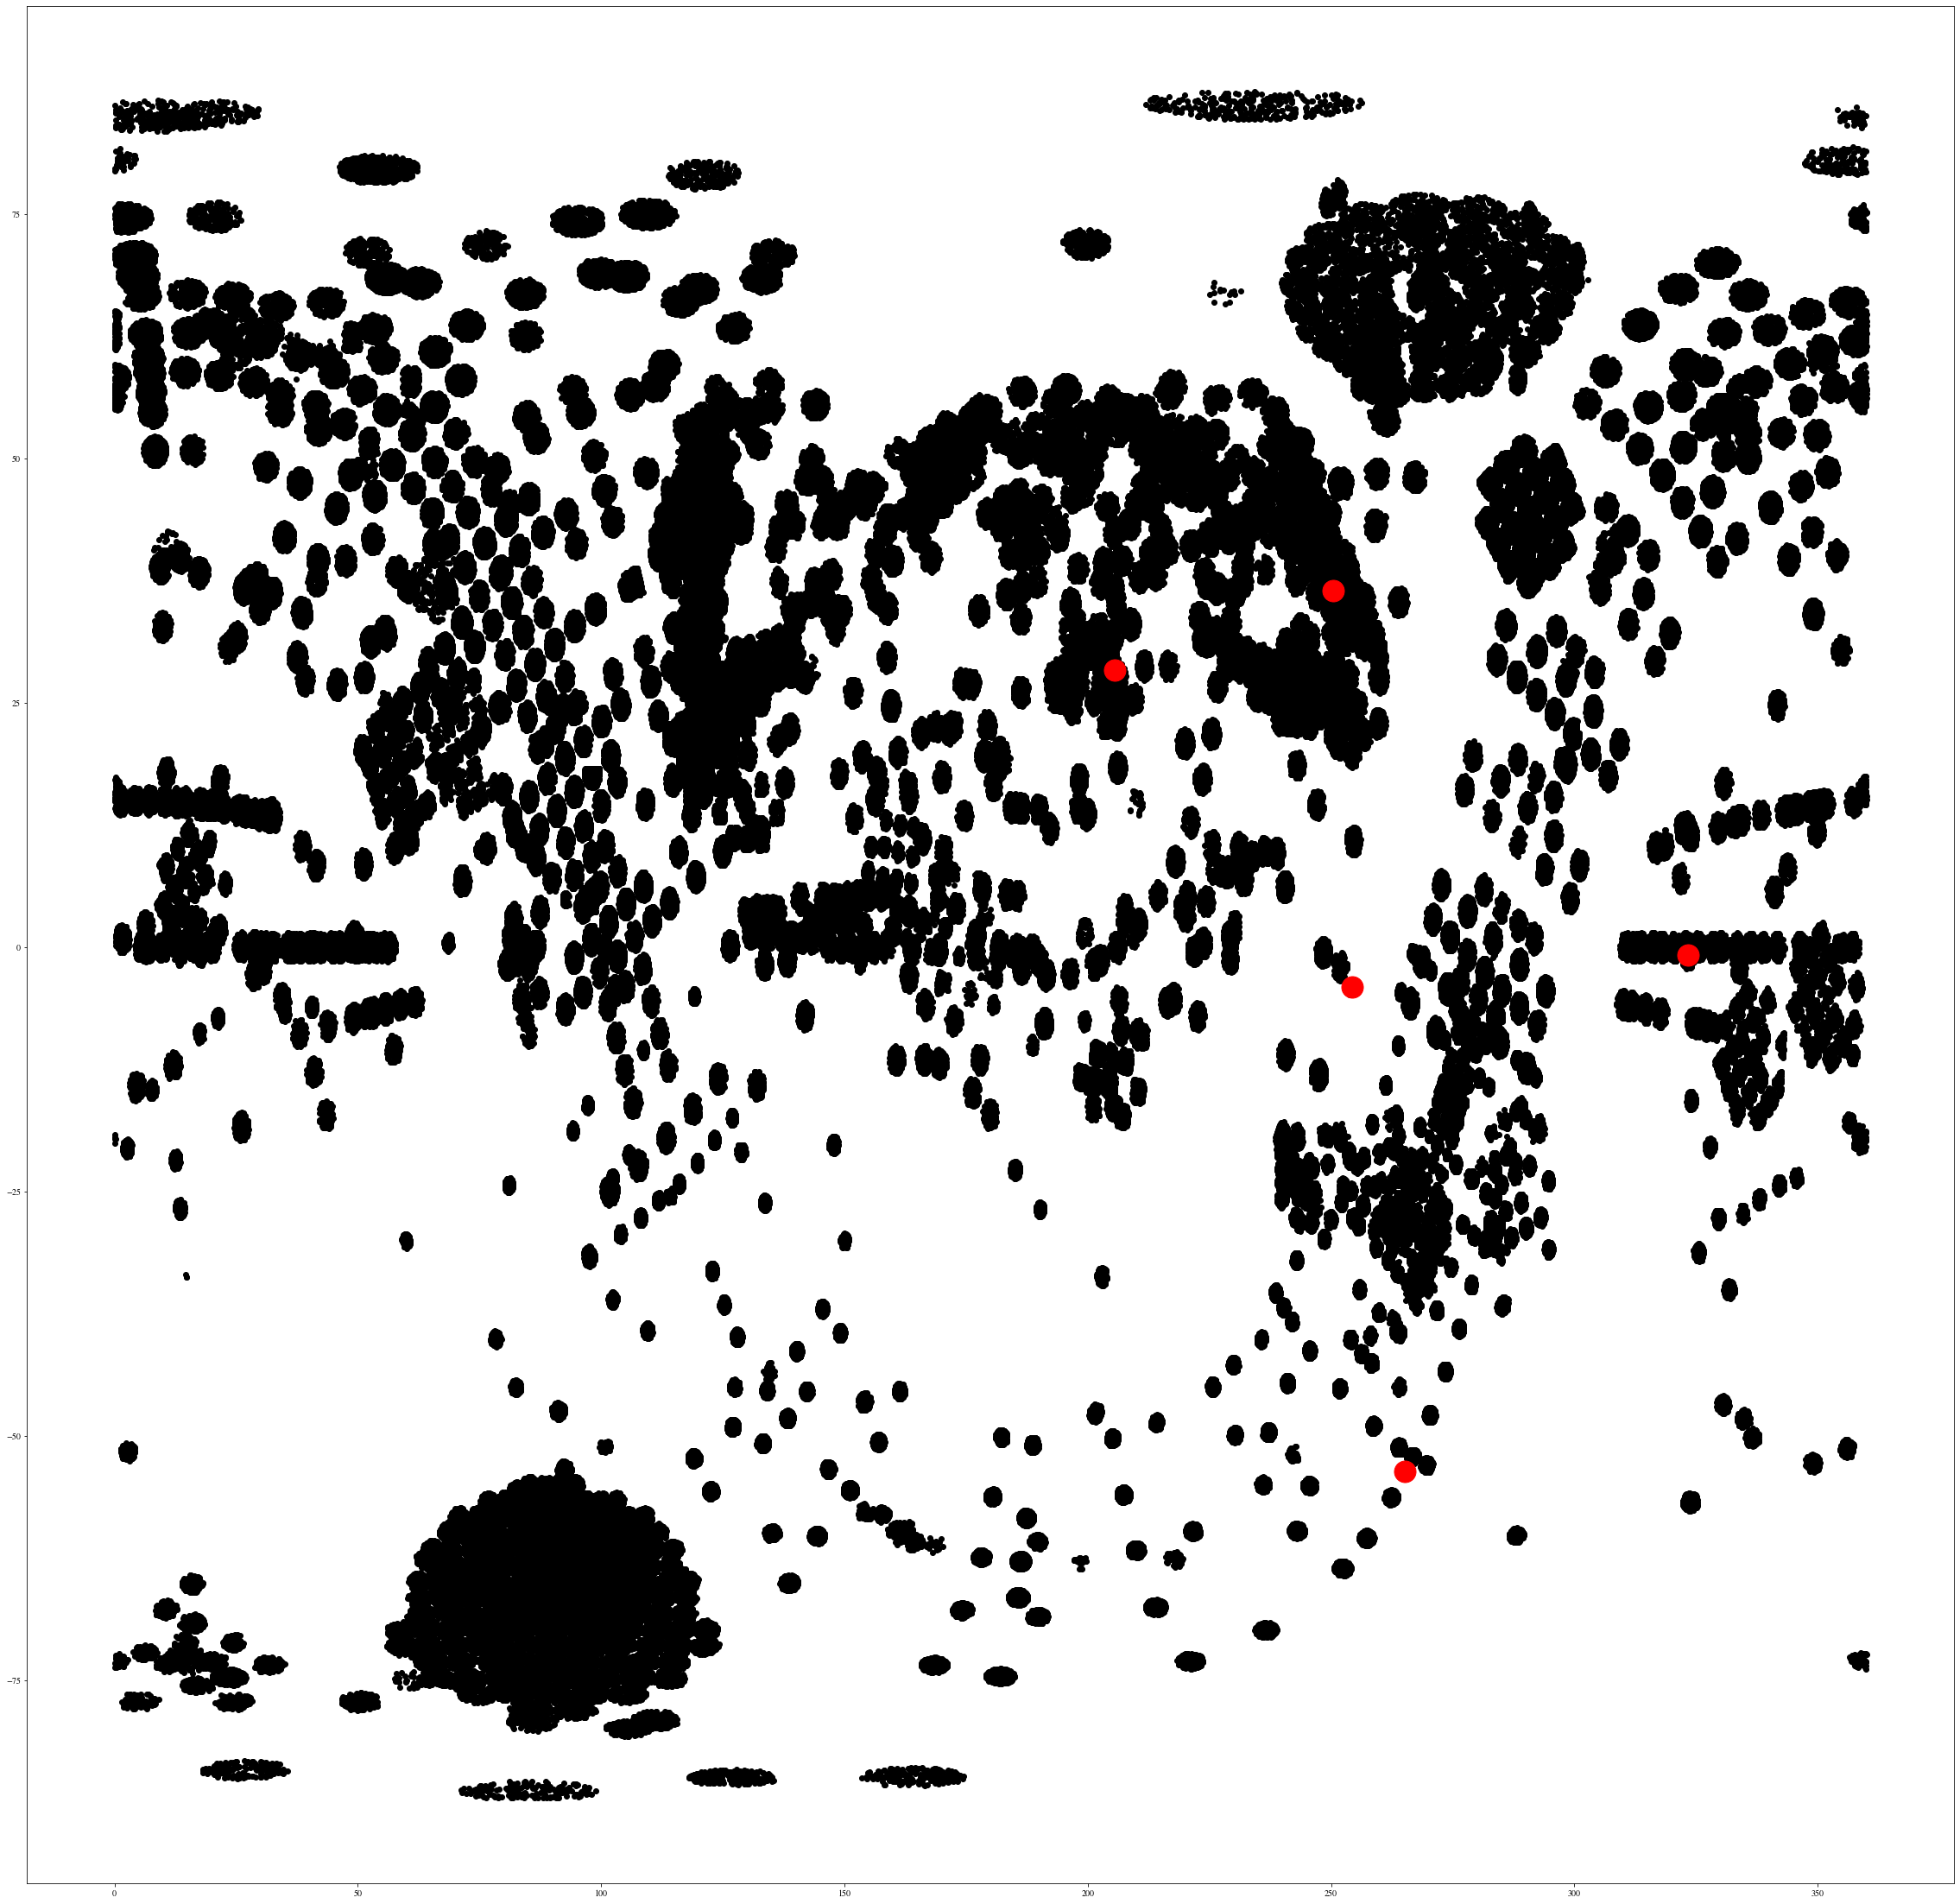

In [69]:
plt.figure(figsize=(40,40))
plt.plot(apogee_nofilt['RA'].values, apogee_nofilt['DEC'].values, 'ok', linewidth=1, linestyle='none')
plt.plot(ra_M3, dec_M3, 'or', markersize=25)
plt.plot(ra_M13, dec_M13, 'or', markersize=25)
plt.plot(ra_M2, dec_M2, 'or', markersize=25)
plt.plot(ra_M10, dec_M10, 'or', markersize=25)
plt.plot(ra_NGC6397, dec_NGC6397, 'or', markersize=25)

#### M3

For all 19 abundances and RV

1906 stars in a 10x10 fov of the GC


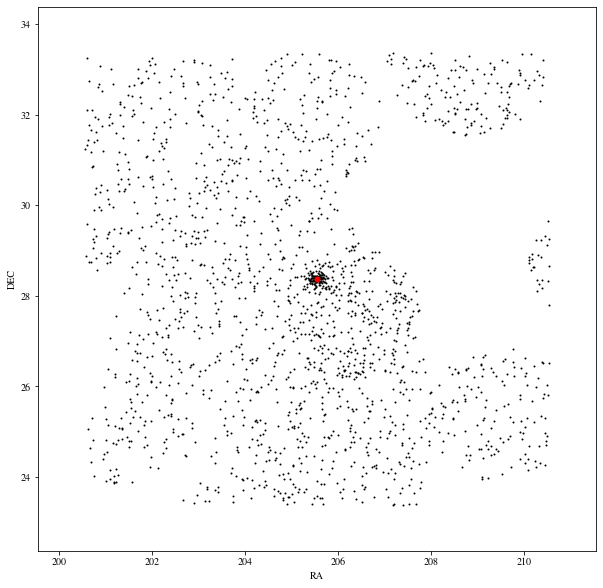

There are 1891 stars in our sample after the proper motion filtering.
There are 1891 stars in our sample after the abundance filtering.
There are 1891 stars that do not have duplicate spectra.
There are 0 stars that have multiple spectra, in which we select highest SNR.
There were no duplicate spectra.
There are 1891 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1891
There are 115 stars in our GC control group.
Do you want to keep FE_H as a parameter? [y/n]y
Do you want to keep C_FE as a parameter? [y/n]y
Do you want to keep CI_FE as a parameter? [y/n]y
Do you want to keep N_FE as a parameter? [y/n]y
Do you want to keep O_FE as a parameter? [y/n]y
Do you want to keep MG_FE as a parameter? [y/n]y
Do you want to keep AL_FE as a parameter? [y/n]y
Do you want to keep SI_FE as a parameter? [y/n]y
Do you want to keep P_FE as a parameter? [y/n]y
Do you want to keep S_FE as a parameter? [y/n]y
Do you want to keep K_FE as a parameter? [y/n

<ipython-input-15-b8c72c15379e>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimX_control = t_SNE_dimX[indices_control]
<ipython-input-15-b8c72c15379e>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimY_control = t_SNE_dimY[indices_control]


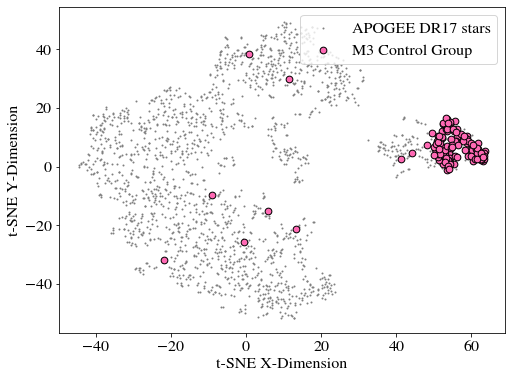

Total:  1891 Control:  115
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-57-b41f3309e096>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimX_control = umap_dimX[indices_control]
<ipython-input-57-b41f3309e096>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimY_control = umap_dimY[indices_control]


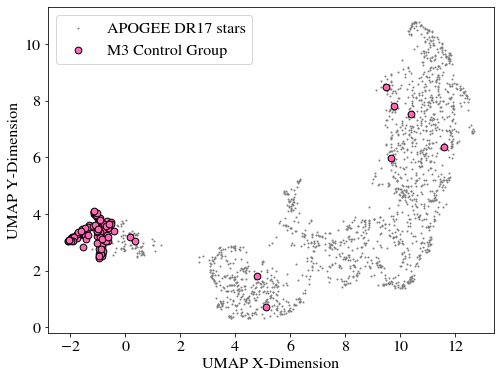

Total: 1891 control: 115
Done!


In [70]:
M3_tSNE_X, M3_tSNE_Y, M3_tSNE_control_X, M3_tSNE_control_Y, M3_UMAP_X, M3_UMAP_Y, M3_UMAP_control_X, M3_UMAP_control_Y = master_func(ra_M3, dec_M3, rhm_M3_deg, all_param_dict, fov, apogee_nofilt, param_list)

#### M13

2345 stars in a 10x10 fov of the GC


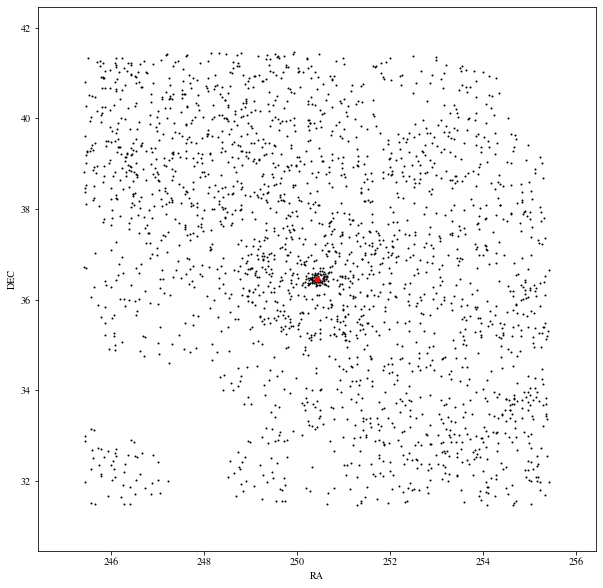

There are 2324 stars in our sample after the proper motion filtering.
There are 2324 stars in our sample after the abundance filtering.
There are 2324 stars that do not have duplicate spectra.
There are 0 stars that have multiple spectra, in which we select highest SNR.
There were no duplicate spectra.
There are 2324 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 2324
There are 78 stars in our GC control group.
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-15-b8c72c15379e>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimX_control = t_SNE_dimX[indices_control]
<ipython-input-15-b8c72c15379e>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimY_control = t_SNE_dimY[indices_control]


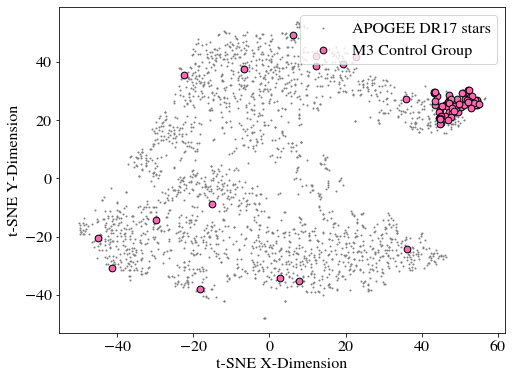

Total:  2324 Control:  78
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-17-3d6442f001b3>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimX_control = umap_dimX[indices_control]
<ipython-input-17-3d6442f001b3>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimY_control = umap_dimY[indices_control]


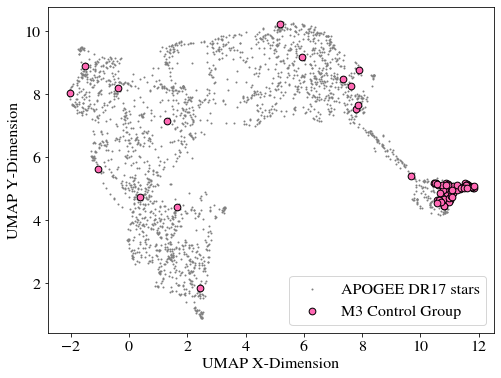

Total: 2324 control: 78
Done!


In [50]:
M13_tSNE_X, M13_tSNE_Y, M13_tSNE_control_X, M13_tSNE_control_Y, M13_UMAP_X, M13_UMAP_Y, M13_UMAP_control_X, M13_UMAP_control_Y = master_func(ra_M13, dec_M13, rhm_M13_deg, all_param_dict, fov, apogee_nofilt1, param_list)

#### M2

785 stars in a 10x10 fov of the GC


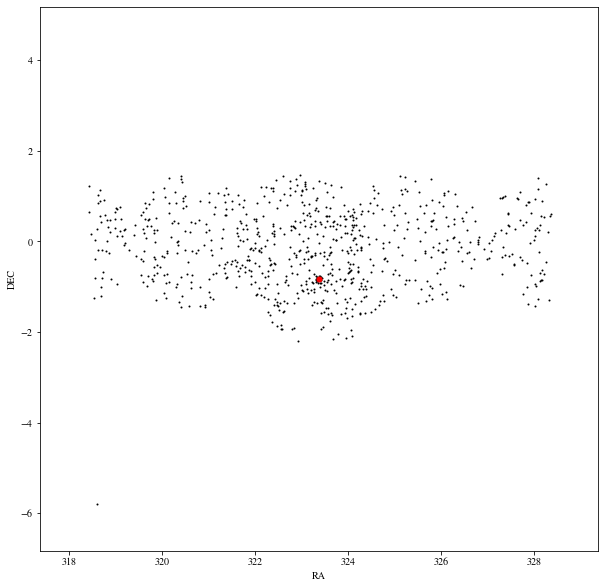

There are 779 stars in our sample after the proper motion filtering.
There are 779 stars in our sample after the abundance filtering.
There are 779 stars that do not have duplicate spectra.
There are 0 stars that have multiple spectra, in which we select highest SNR.
There were no duplicate spectra.
There are 779 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 779
There are 25 stars in our GC control group.
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-15-b8c72c15379e>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimX_control = t_SNE_dimX[indices_control]
<ipython-input-15-b8c72c15379e>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimY_control = t_SNE_dimY[indices_control]


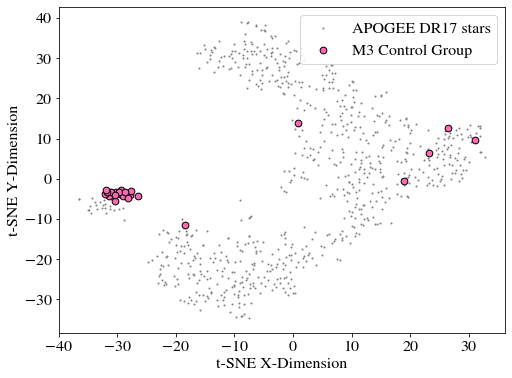

Total:  779 Control:  25
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-17-3d6442f001b3>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimX_control = umap_dimX[indices_control]
<ipython-input-17-3d6442f001b3>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimY_control = umap_dimY[indices_control]


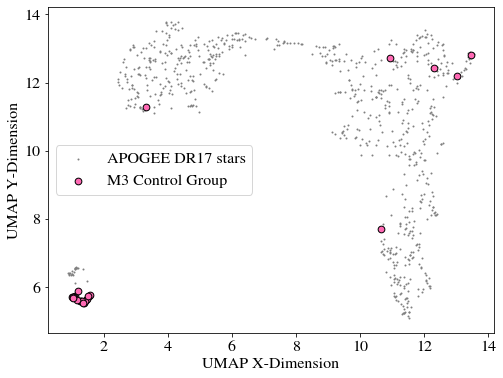

Total: 779 control: 25
Done!


In [51]:
M2_tSNE_X, M2_tSNE_Y, M2_tSNE_control_X, M2_tSNE_control_Y, M2_UMAP_X, M2_UMAP_Y, M2_UMAP_control_X, M2_UMAP_control_Y = master_func(ra_M2, dec_M2, rhm_M2_deg, all_param_dict, fov, apogee_nofilt, param_list)

#### M12

986 stars in a 10x10 fov of the GC


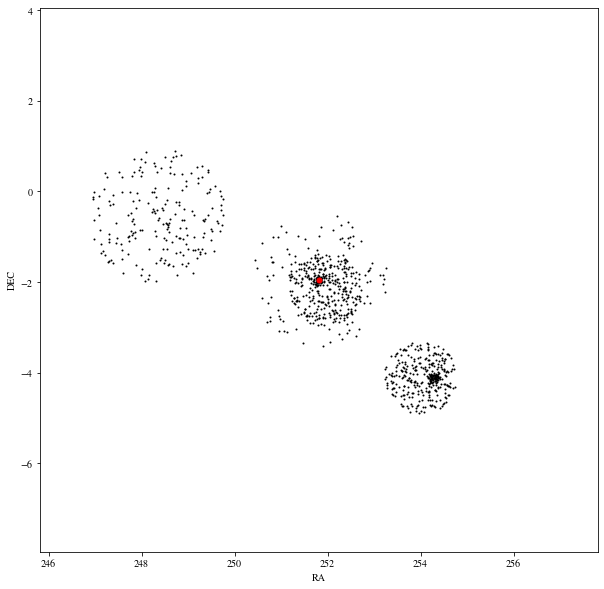

There are 981 stars in our sample after the proper motion filtering.
There are 981 stars in our sample after the abundance filtering.
There are 981 stars that do not have duplicate spectra.
There are 0 stars that have multiple spectra, in which we select highest SNR.
There were no duplicate spectra.
There are 981 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 981
There are 129 stars in our GC control group.
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-15-b8c72c15379e>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimX_control = t_SNE_dimX[indices_control]
<ipython-input-15-b8c72c15379e>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimY_control = t_SNE_dimY[indices_control]


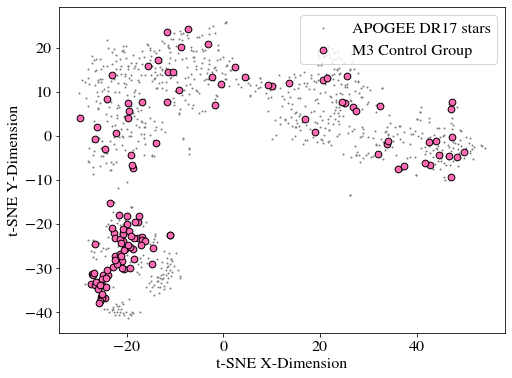

Total:  981 Control:  129
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-17-3d6442f001b3>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimX_control = umap_dimX[indices_control]
<ipython-input-17-3d6442f001b3>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimY_control = umap_dimY[indices_control]


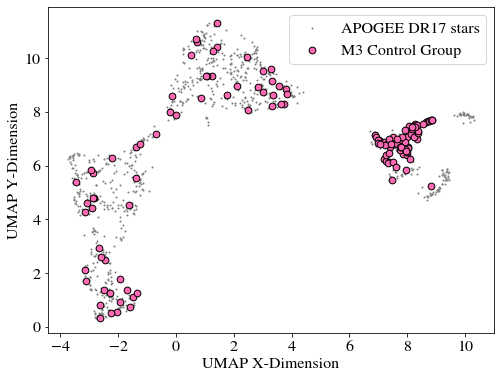

Total: 981 control: 129
Done!


In [52]:
M12_tSNE_X, M12_tSNE_Y, M12_tSNE_control_X, M12_tSNE_control_Y, M12_UMAP_X, M12_UMAP_Y, M12_UMAP_control_X, M12_UMAP_control_Y = master_func(ra_M12, dec_M12, rhm_M12_deg, all_param_dict, fov, apogee_nofilt, param_list)

#### M10

815 stars in a 10x10 fov of the GC


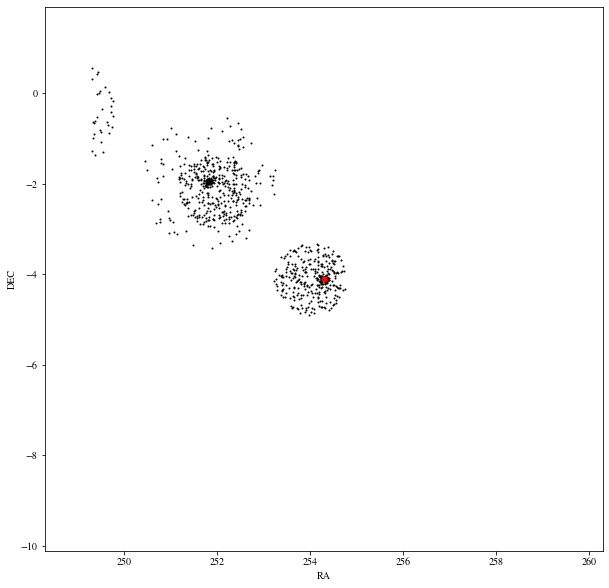

There are 811 stars in our sample after the proper motion filtering.
There are 811 stars in our sample after the abundance filtering.
There are 811 stars that do not have duplicate spectra.
There are 0 stars that have multiple spectra, in which we select highest SNR.
There were no duplicate spectra.
There are 811 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 811
There are 155 stars in our GC control group.
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-15-b8c72c15379e>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimX_control = t_SNE_dimX[indices_control]
<ipython-input-15-b8c72c15379e>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimY_control = t_SNE_dimY[indices_control]


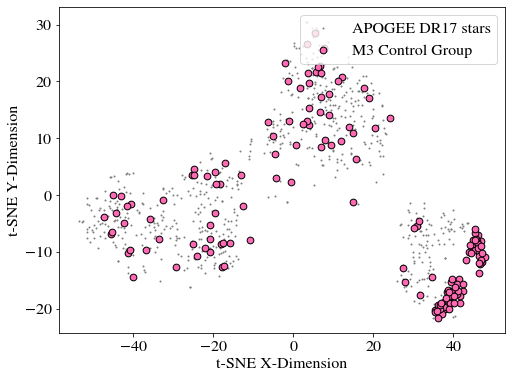

Total:  811 Control:  155
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-17-3d6442f001b3>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimX_control = umap_dimX[indices_control]
<ipython-input-17-3d6442f001b3>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimY_control = umap_dimY[indices_control]


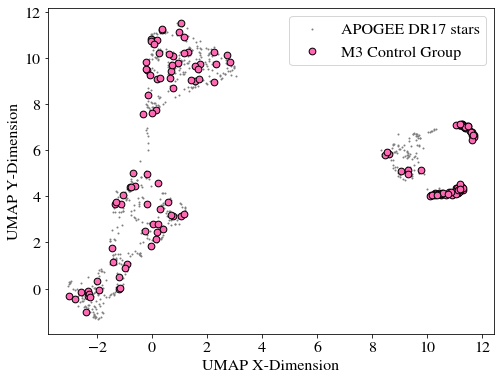

Total: 811 control: 155
Done!


In [53]:
M10_tSNE_X, M10_tSNE_Y, M10_tSNE_control_X, M10_tSNE_control_Y, M10_UMAP_X, M10_UMAP_Y, M10_UMAP_control_X, M10_UMAP_control_Y = master_func(ra_M10, dec_M10, rhm_M10_deg, all_param_dict, fov, apogee_nofilt, param_list)

#### NGC6397

1107 stars in a 10x10 fov of the GC


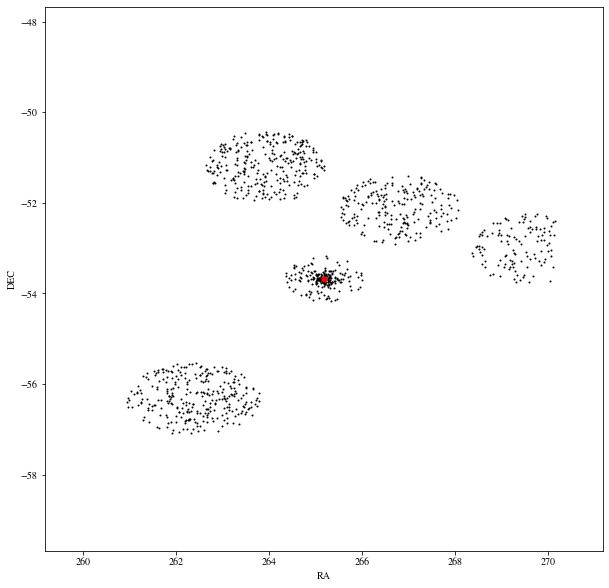

There are 1106 stars in our sample after the proper motion filtering.
There are 1106 stars in our sample after the abundance filtering.
There are 1106 stars that do not have duplicate spectra.
There are 0 stars that have multiple spectra, in which we select highest SNR.
There were no duplicate spectra.
There are 1106 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1106
There are 189 stars in our GC control group.
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-15-b8c72c15379e>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimX_control = t_SNE_dimX[indices_control]
<ipython-input-15-b8c72c15379e>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tsne_dimY_control = t_SNE_dimY[indices_control]


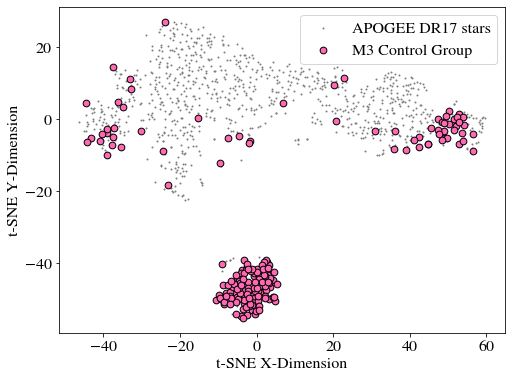

Total:  1106 Control:  189
The chosen parameters for tSNE and UMAP were: ['FE_H', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'RV', 'PMRA', 'PMDEC']


<ipython-input-17-3d6442f001b3>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimX_control = umap_dimX[indices_control]
<ipython-input-17-3d6442f001b3>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  umap_dimY_control = umap_dimY[indices_control]


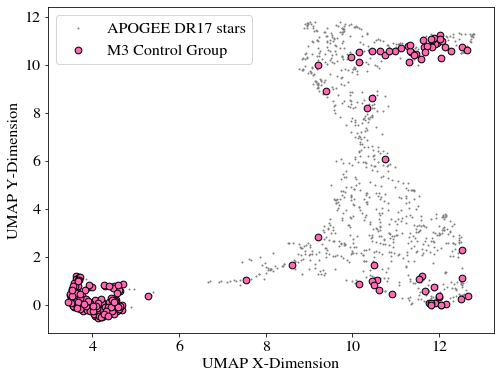

Total: 1106 control: 189
Done!


In [54]:
NGC6397_tSNE_X, NGC6397_tSNE_Y, NGC6397_tSNE_control_X, NGC6397_tSNE_control_Y, NGC6397_UMAP_X, NGC6397_UMAP_Y, NGC6397_UMAP_control_X, NGC6397_UMAP_control_Y = master_func(ra_NGC6397, dec_NGC6397, rhm_NGC6397_deg, all_param_dict, fov, apogee_nofilt, param_list)

#### Changing Perplexity (default 30)
related to # of nearby neighbours. Not sure what specifically

In [ ]:
### Perplexity changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# perplexity list (default 30)
perp_list = [5, 10, 15, 20, 25, 35, 40, 45, 50]
t_SNE_dimX_perp = []
t_SNE_dimY_perp = []
tsne_dimX_control_perp = []
tsne_dimY_control_perp = []
for i in perp_list:
    tsne_init_perp = TSNE(n_components=2, perplexity=i)
    tsne_2d_perp = tsne_init_perp.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_perp.append(tsne_2d_perp[:, 0])
    t_SNE_dimY_perp.append(tsne_2d_perp[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_perp.append(t_SNE_dimX_perp[-1][indices_control])
    tsne_dimY_control_perp.append(t_SNE_dimY_perp[-1][indices_control])
    
    print('t_SNE done for perp =', i)

print('t_SNE done')

In [ ]:
fig_perp, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_perp[i + 3 * j], t_SNE_dimY_perp[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_perp[i + 3 * j], tsne_dimY_control_perp[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for perp =' + str(perp_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_list[i + 3*j]), 'Control: ', len(tsne_dimX_control_list[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_perp')
plt.show()



Seems like the higher the perplexity, the more tightly grouped together the control stars. After 20 there seems to be a drop off in terms of cluster tightness increase. Running the same code doesn't yield the same graphs?

#### Changing early exaggeration (default 12)
controls tightness of natural clusters and how much space will be in between them?

In [ ]:
### early exaggeration changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# early exaggeration list (default 12.)
exg_list = [4., 8., 16., 20., 24., 28., 32., 36., 40.]
t_SNE_dimX_exg = []
t_SNE_dimY_exg = []
tsne_dimX_control_exg = []
tsne_dimY_control_exg = []
for i in exg_list:
    tsne_init_exg = TSNE(n_components=2, perplexity=i)
    tsne_2d_exg = tsne_init_exg.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_exg.append(tsne_2d_exg[:, 0])
    t_SNE_dimY_exg.append(tsne_2d_exg[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_exg.append(t_SNE_dimX_exg[-1][indices_control])
    tsne_dimY_control_exg.append(t_SNE_dimY_exg[-1][indices_control])
    
    print('t_SNE done for exg =', i)

print('t_SNE done')

In [ ]:
fig_exg, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_exg[i + 3 * j], t_SNE_dimY_exg[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_exg[i + 3 * j], tsne_dimY_control_exg[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for early exg =' + str(exg_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_exg[i + 3*j]), 'Control: ', len(tsne_dimX_control_exg[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_exg')
plt.show()



Seems like higher early exaggeration leads to tighter groups. Just like perplexity, there seems to be a falloff in group tightness increase

#### Changing learning rate (default 200)
something to do with step size and optimization for ML algorithms i think

In [ ]:
### early exaggeration changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# early exaggeration list (default 12.)
learn_list = [10., 100., 300., 400., 500., 600., 700., 800., 900.]
t_SNE_dimX_learn = []
t_SNE_dimY_learn = []
tsne_dimX_control_learn = []
tsne_dimY_control_learn = []
for i in learn_list:
    tsne_init_learn = TSNE(n_components=2, learning_rate=i)
    tsne_2d_learn = tsne_init_learn.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_learn.append(tsne_2d_learn[:, 0])
    t_SNE_dimY_learn.append(tsne_2d_learn[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_learn.append(t_SNE_dimX_learn[-1][indices_control])
    tsne_dimY_control_learn.append(t_SNE_dimY_learn[-1][indices_control])
    
    print('t_SNE done for learn =', i)

print('t_SNE done')

In [ ]:
fig_learn, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_learn[i + 3 * j], t_SNE_dimY_learn[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_learn[i + 3 * j], tsne_dimY_control_learn[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for learning rate =' + str(exg_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_exg[i + 3*j]), 'Control: ', len(tsne_dimX_control_exg[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_learn')
plt.show()

Not too much noticable change surprisingly.

### OVerall remarks

Seems to have a similar structure each time, just different control group locations and orientations

#### ***CHECK-IN: You succesfully ran t-SNE!*

What does this specific t-SNE projection actually tell you? How could you improve this t-SNE run? Importantly, how could you extend this method to find extra-tidal candidates of M3?

This specific t-SNE only tells us the likely control group stars of M3 and where they fall in parameter space. A further analysis of the other stars that are similar to the M3 control group stars could identify extra tidal candidates.

#### Improving the Dimensionality Reduction
Fine tune the hyper-parameters:
- understand how the different hyper-parameters affect the data
- what combination of hyper-parameters achieve the best separation of the control group? to acheive the best 

Helpful Papers:

https://distill.pub/2016/misread-tsne/ 

https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868 

Dimensional Reduction Astronomy Example:
https://arxiv.org/pdf/2210.02471.pdf
